<a href="https://colab.research.google.com/github/JuanIgnaMurua/Grupo-6-ISPC-Proyecto-HotelExplora/blob/main/Predicci%C3%B3n_Hotel_rating_V2.2.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wordcloud

In [ ]:
# PASO 1: Importar librerías y configuraciones iniciales
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from wordcloud import WordCloud, STOPWORDS

In [ ]:
# PASO 2: Cargar los datos
data = pd.read_csv('/content/7282_1.csv', engine='python', on_bad_lines='skip')
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [ ]:
# PASO 3: Preprocesar los datos
#Filtrar calificaciones que son 0
data = data[data['reviews.rating']>0]
#Cambiar el nombre de los nombres de las columnas que tienen un '.' en ellos
data = data.rename(index=str, columns={'reviews.date':'reviewsdate', 'reviews.dateAdded':'reviewsdateAdded',
       'reviews.doRecommend':'reviewsdoRecommend', 'reviews.id':'reviewsid', 'reviews.rating':'reviewsrating', 'reviews.text':'reviewstext',
       'reviews.title':'reviewstitle', 'reviews.userCity':'reviewsuserCity', 'reviews.username':'reviewsusername',
       'reviews.userProvince':'reviewsuserProvince'})
data.reviewstext = data.reviewstext.fillna('x')
#Unas pocas centenas de valoraciones tenían una puntuación superior a 5, filtrando estas
data = data[data['reviewsrating']<=5]
#Unas pocas centenas de valoraciones tenían decimales, redondeando cada una de estas hacia abajo a un entero.
data.reviewsrating = data.reviewsrating.astype(int)


In [ ]:
data.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviewsdate,reviewsdateAdded,reviewsdoRecommend,reviewsid,reviewsrating,reviewstext,reviewstitle,reviewsuserCity,reviewsusername,reviewsuserProvince
60,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,2016-02-19T00:00:00Z,2015-10-21T17:46:10Z,NaN,NaN,5,"We had a wonderful, relaxing time. The staff w...",Hospitality at its Best!,Albany,Flo H,NY
61,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,2016-06-25T00:00:00Z,2015-10-21T17:46:10Z,NaN,NaN,5,We were in Palm Springs on the day the tempera...,Pure delight!,North Houston,Julie R,TX
62,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,2016-08-01T00:00:00Z,2015-10-21T17:46:10Z,NaN,NaN,5,We arrived in Palm Springs not sure what to ex...,Awesome! Quiet secluded tranquility,North Houston,martin n,TX
63,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,2016-06-08T00:00:00Z,2015-10-21T17:46:10Z,NaN,NaN,5,This place really is a little paradise!! A bea...,As the title suggests....,Los Angeles,shetravels66,CA
64,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,2016-03-17T00:00:00Z,2015-10-21T17:46:10Z,NaN,NaN,5,Spent 3 nights at Little Paradise boutique hot...,Loved this Wonderful Boutique Hotel!,Los Angeles,Mary Ellen R,CA


In [ ]:
#PASO 4: Crear una función para limpiar las reseñas
#Crearé una función que usaré para limpiar cadenas de reseñas. La función hará lo siguiente con la cadena 'txt': Convertirá la cadena a minúsculas.Eliminará las palabras vacías (stopwords).Encontrará la longitud de la cadena limpia.Extraerá solo los adjetivos. Devolverá una lista con la longitud de la cadena limpia, la cadena limpia y la cadena que contiene solo adjetivos.
def cleanme(txt):
    sent = txt.lower()
    wrds = word_tokenize(sent)
    clwrds = [w for w in wrds if not w in stopwords.words('english')]
    ln = len(clwrds)
    pos = pd.DataFrame(pos_tag(wrds))
    pos = " ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))
    rt = [ln, " ".join(clwrds), pos]
    return(rt)

In [ ]:
# PASO 5: Mostrar los países únicos en los datos
unique_countries = data['country'].unique()

# Muestra la lista de países únicos
print("Unique countries in the dataset:")
for country in unique_countries:
    print(country)

Unique countries in the dataset:
US


In [ ]:
# PASO 6: Visualizar la ubicación de las reseñas de hoteles
plt1 = go.Scatter(x = data.longitude, y=data.latitude, mode = 'markers')
lyt1 = go.Layout(title="Locations of Hotel Reviews", xaxis=dict(title='Longitude'), yaxis=dict(title='Latitude'))
fig1 = go.Figure(data=[plt1], layout=lyt1)
iplot(fig1)

In [ ]:
# PASO 7: Filtrar datos para incluir solo los puntos dentro de los EE.UU.
data = data[((data['latitude']<=50.0) & (data['latitude']>=24.0)) & ((data['longitude']<=-65.0) & (data['longitude']>=-122.0))]

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
# PASO 8: Crear un campo que muestre la longitud de cada reseña
tmp = list()
for i in range(len(data)):
    tmp.append(cleanme(data.iloc[i,:]['reviewstext']))
tmp = pd.DataFrame(tmp)
tmp.columns = ['reviewlen', 'cleanrev', 'adjreview']

In [ ]:
# PASO 9: Añadir columnas calculadas de nuevo al conjunto de datos
data = data.reset_index()
data = pd.concat([data,tmp], axis=1)
data

,index,address,categories,city,country,latitude,longitude,name,postalCode,province,...,reviewsid,reviewsrating,reviewstext,reviewstitle,reviewsuserCity,reviewsusername,reviewsuserProvince,reviewlen,cleanrev,adjreview
0,60,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,...,NaN,5,"We had a wonderful, relaxing time. The staff w...",Hospitality at its Best!,Albany,Flo H,NY,36,"wonderful , relaxing time . staff completely a...",wonderful relaxing attentive deluxe available ...
1,61,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,...,NaN,5,We were in Palm Springs on the day the tempera...,Pure delight!,North Houston,Julie R,TX,37,palm springs day temperature 123 degrees ! des...,palm wonderful little paradise friendly little...
2,62,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,...,NaN,5,We arrived in Palm Springs not sure what to ex...,Awesome! Quiet secluded tranquility,North Houston,martin n,TX,42,arrived palm springs sure expect .... 's quiet...,sure quiet residential wooden sure spacious we...
3,63,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,...,NaN,5,This place really is a little paradise!! A bea...,As the title suggests....,Los Angeles,shetravels66,CA,44,place really little paradise ! ! beautiful bou...,little beautiful fresh best comfortable wonder...
4,64,435 E Avenida Olancha,"Hotels,Hotel",Palm Springs,US,33.802822,-116.54269,Little Paradise Hotel,92264,CA,...,NaN,5,Spent 3 nights at Little Paradise boutique hot...,Loved this Wonderful Boutique Hotel!,Los Angeles,Mary Ellen R,CA,45,spent 3 nights little paradise boutique hotel ...,little paradise mother-daughter wonderful rela...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5739,6610,2597 Holiday Rd,Hotels,Coralville,US,41.700640,-91.60700,Americinn Coralville,52241,IA,...,NaN,3,Good price. Hallways were dirty. Not a welcomi...,Just okay,University Park,A Traveler,IA,17,good price . hallways dirty . welcoming lobby ...,good welcoming poor
5740,6611,2597 Holiday Rd,Hotels,Coralville,US,41.700640,-91.60700,Americinn Coralville,52241,IA,...,NaN,5,My first time at Americinn Property - I was dr...,Good Traveller hotel,University Park,Henry,IA,30,first time americinn property - driving cross-...,first americinn clean quite nice i nice mid-price
5741,6612,2597 Holiday Rd,Hotels,Coralville,US,41.700640,-91.60700,Americinn Coralville,52241,IA,...,NaN,1,"First of all, there was only one person at the...",Not a great place to stay.,University Park,JOAN,IA,67,"first , one person front desk , stand line 1/2...",nonsmoking stale p-tac last impressive top fur...
5742,6613,2597 Holiday Rd,Hotels,Coralville,US,41.700640,-91.60700,Americinn Coralville,52241,IA,...,NaN,3,"The lobby was hot, the beds were extremely unc...",Great Pool,University Park,Christine,IA,29,"lobby hot , beds extremely uncomfortable , bat...",hot uncomfortable clean generous hot large per...


In [ ]:
# PASO 10: Visualizar la frecuencia de la longitud de las reseñas
plt2 = go.Histogram(x = data.reviewlen)
lyt2 = go.Layout(title="Frequency of Review Length", xaxis=dict(title='Review Length', range=[0,400]), yaxis=dict(title='Frequency'))
fig2 = go.Figure(data=[plt2], layout=lyt2)
iplot(fig2)

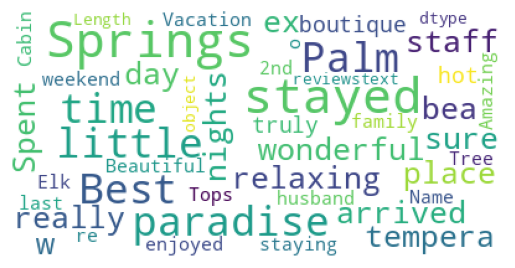

In [ ]:
# PASO 11: Crear y mostrar una nube de palabras
mpl.rcParams['font.size']=12                #10
mpl.rcParams['savefig.dpi']=100             #72
mpl.rcParams['figure.subplot.bottom']=.1
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
    background_color='white',
    stopwords=STOPWORDS,
    max_words=200,
    max_font_size=40,
    random_state=42
).generate(str(data['reviewstext']))


plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
# PASO 12: Visualizar la longitud de las reseñas frente a la calificación
data = data.sort_values(by='reviewlen')
plt3 = go.Scatter(x = data.reviewlen, y = data.reviewsrating, mode='markers')
lyt3 = go.Layout(title="Review Length vs. Star Rating", xaxis=dict(title='Review Length'),yaxis=dict(title='Rating'))
fig3 = go.Figure(data=[plt3], layout=lyt3)
iplot(fig3)
print("Review Length to Rating Correlation:",data.reviewlen.corr(data.reviewsrating))

Review Length to Rating Correlation: -0.1605662318320769


In [ ]:
# PASO 13: Configurar los datos X e Y para los modelos de machine learning
#Setting up the X and Y data, where X is the review text and Y is the rating
#Three different inputs will be used: original review text, cleaned review text, and only adjectives review text
x1 = data.reviewstext
x2 = data.cleanrev
x3 = data.adjreview
y = data.reviewsrating

In [ ]:
# PASO 14: Crear un vectorizador para dividir el texto en unigrams y bigrams
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect1 = vect.fit_transform(x1)
x_vect2 = vect.fit_transform(x2)
x_vect3 = vect.fit_transform(x3)

In [ ]:
# PASO 15: Definir funciones para Linear SVC, KNN y Naive Bayes
def entrenar_linsvc(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=10)
    classf = LinearSVC(dual=False)
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print("Linear SVC Accuracy:", accuracy)
    return classf, accuracy

def entrenar_knn(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=10)
    classf = KNeighborsClassifier(n_neighbors=2)
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print("KNN Accuracy:", accuracy)
    return classf, accuracy

def entrenar_naive_bayes(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=10)
    classf = MultinomialNB()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    print("Naive Bayes Accuracy:", accuracy)
    return classf, accuracy

In [ ]:
# PASO 16: Entrenar y evaluar los modelos
svm_model, svm_accuracy = entrenar_linsvc(x_vect2, y)
knn_model, knn_accuracy = entrenar_knn(x_vect2, y)
nb_model, nb_accuracy = entrenar_naive_bayes(x_vect2, y)

# Comparamos las precisiones
print("Linear SVC Accuracy:", svm_accuracy)
print("KNN Accuracy:", knn_accuracy)
print("Naive Bayes Accuracy:", nb_accuracy)

Linear SVC Accuracy: 0.5104456824512534
KNN Accuracy: 0.28342618384401114
Naive Bayes Accuracy: 0.42896935933147634
Linear SVC Accuracy: 0.5104456824512534
KNN Accuracy: 0.28342618384401114
Naive Bayes Accuracy: 0.42896935933147634


In [ ]:
# Crear y mostrar una matriz de confusión
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
  Esta función imprime y traza la matriz de confusión.
 La normalización se puede aplicar configurando `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]),decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 306   18   20   23   29]
 [  10  321   23   37   27]
 [   7   11  605  101   76]
 [   2    6   23 1379  241]
 [   5    3    7  121 2343]]
Confusion matrix, without normalization
[[ 287    3    0  106    0]
 [   5  307    2  104    0]
 [   7    6  577  210    0]
 [   4    6   16 1619    6]
 [   7    2   17 2369   84]]
Confusion matrix, without normalization
[[   0    0    0   11  385]
 [   0    0    0   27  391]
 [   0    0   14   37  749]
 [   0    0    0  605 1046]
 [   0    0    0    4 2475]]


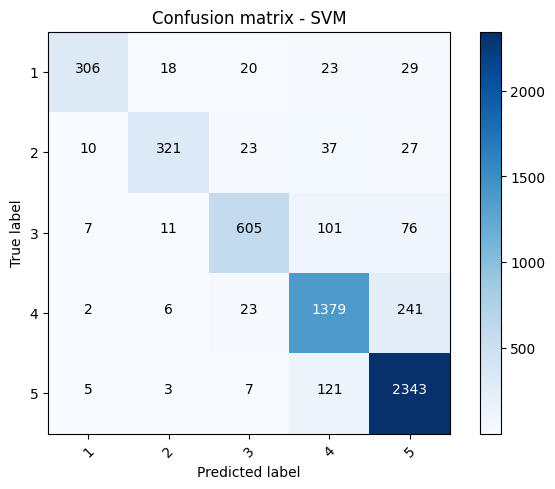

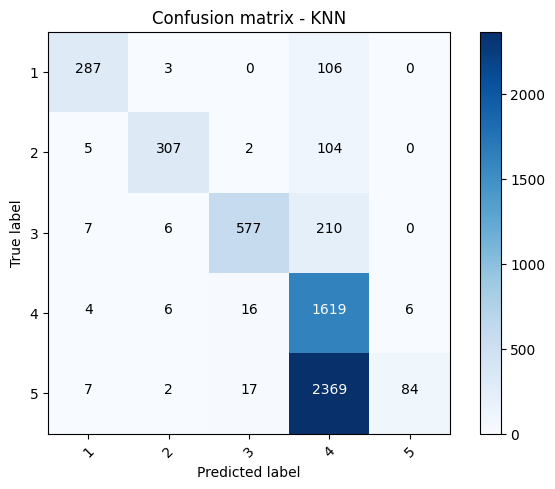

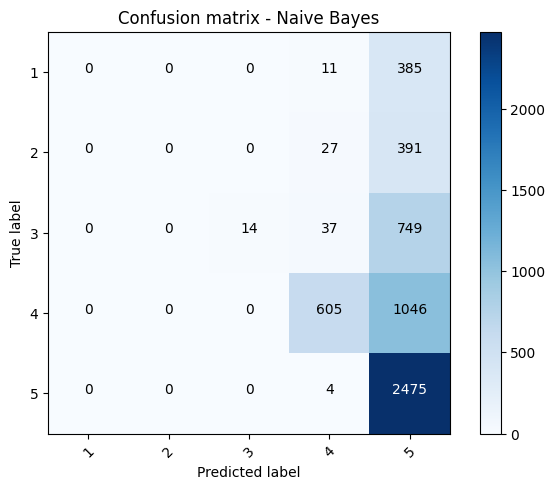

In [ ]:
# Generar y graficar las matrices de confusión
c1 = confusion_matrix(y, svm_model.predict(x_vect2))
c2 = confusion_matrix(y, knn_model.predict(x_vect2))
c3 = confusion_matrix(y, nb_model.predict(x_vect2))
class_names = ['1', '2', '3', '4', '5']
plt.figure()
plot_confusion_matrix(c1, classes=class_names, normalize=False, title='Confusion matrix - SVM')
plt.figure()
plot_confusion_matrix(c2, classes=class_names, normalize=False, title='Confusion matrix - KNN')
plt.figure()
plot_confusion_matrix(c3, classes=class_names, normalize=False, title='Confusion matrix - Naive Bayes')
plt.show()


In [ ]:
print(data.columns)

Index(['index', 'address', 'categories', 'city', 'country', 'latitude',
       'longitude', 'name', 'postalCode', 'province', 'reviewsdate',
       'reviewsdateAdded', 'reviewsdoRecommend', 'reviewsid', 'reviewsrating',
       'reviewstext', 'reviewstitle', 'reviewsuserCity', 'reviewsusername',
       'reviewsuserProvince', 'reviewlen', 'cleanrev', 'adjreview'],
      dtype='object')


In [ ]:
city_list = data['city'].tolist()

In [ ]:
print(city_list)

['Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Palm Springs', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Houston', 'Glendale', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermore', 'Livermo

##**Sistema de recomendación y de clasificación de hoteles por rating y ciudad utilizando NLP**##

Este código define una función hotel_recommendation_by_city_rating que recomienda hoteles en una ciudad dada con una clasificación dentro de un rango específico. Filtra los datos según la ciudad y el rango de clasificación, luego calcula el promedio de clasificación para cada hotel y devuelve las tres mejores recomendaciones.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Descargar los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

# Función para limpiar las reseñas
def cleanme(txt):
    sent = txt.lower()
    wrds = word_tokenize(sent)
    clwrds = [w for w in wrds if not w in stopwords.words('english')]
    ln = len(clwrds)
    pos = pd.DataFrame(pos_tag(wrds))
    pos = " ".join(list(pos[pos[1].str.contains("JJ")].iloc[:,0]))
    rt = [ln, " ".join(clwrds), pos]
    return(rt)

# Función para recomendación de hoteles por rating y ciudad
def try_convert_to_numeric(value):
    try:
        return float(value)
    except (TypeError, ValueError):
        return None

def hotel_recommendation_by_city_rating(city, rating, data):
    # Filtrar los datos para la ciudad específica
    city_data = data[data['city'] == city]

    # Filtrar por rating dentro de un rango más amplio
    similar_hotels = city_data[(city_data['reviewsrating'] >= rating - 1) & (city_data['reviewsrating'] <= rating + 1)]

    # Convertir la columna 'reviewsrating' a tipo numérico
    similar_hotels['reviewsrating'] = similar_hotels['reviewsrating'].apply(try_convert_to_numeric)

    # Eliminar filas con valores no numéricos en la columna 'reviewsrating'
    similar_hotels = similar_hotels.dropna(subset=['reviewsrating'])

    # Agrupar por nombre y dirección del hotel y calcular el promedio del rating
    similar_hotels_grouped = similar_hotels.groupby(['name', 'address'])['reviewsrating'].mean().reset_index()

    # Ordenar por rating en orden descendente
    top_recommendations = similar_hotels_grouped.sort_values(by='reviewsrating', ascending=False).head(3)

    return top_recommendations


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
# Ejemplo de uso 1:
city ='New York'
rating = 5
recommendations = hotel_recommendation_by_city_rating(city, rating, data)
print(recommendations)

Empty DataFrame
Columns: [name, address, reviewsrating]
Index: []


In [ ]:
# Ejemplo de uso 2:
city ='Palm Springs'
rating = 5
recommendations = hotel_recommendation_by_city_rating(city, rating, data)
print(recommendations)

                    name                address  reviewsrating
0  Little Paradise Hotel  435 E Avenida Olancha           4.85


# **Sistema de recomendación de hoteles por ciudad y rating usando SVM y TF-ID**

El objetivo del sistema es recomendar hoteles en una ciudad específica con una calificación determinada, utilizando un modelo de máquina de soporte vectorial (SVM) previamente entrenado y un vectorizador TF-IDF. La recomendación se basa en las reseñas de los usuarios.




In [ ]:
def recommend_hotels(city, rating, model, vectorizer, data):
    # Filtrar datos por ciudad y calificación
    filtered_data = data[(data['city'].str.lower() == city.lower()) & (data['reviewsrating'] == rating)]

    if filtered_data.empty:
        print("No se encontraron hoteles en la ciudad y calificación especificadas.")
        return

    # Eliminar duplicados basados en el nombre del hotel
    filtered_data = filtered_data.drop_duplicates(subset=['name'])

    # Limpiar y vectorizar las reseñas filtradas
    cleaned_reviews = filtered_data['reviewstext'].apply(lambda x: cleanme(x)[1])
    x_vect = vectorizer.transform(cleaned_reviews)

    # Realizar predicciones con el modelo
    predictions = model.predict(x_vect)

    # Filtrar las predicciones por la calificación deseada
    recommended_indices = np.where(predictions == rating)[0]

    if len(recommended_indices) == 0:
        print("No se encontraron hoteles con la calificación solicitada.")
        return

    # Obtener hoteles recomendados
    recommended_hotels = filtered_data.iloc[recommended_indices]

    print("Hoteles recomendados en {} con una calificación de {}: \n".format(city, rating))
    for idx, hotel in recommended_hotels.iterrows():
        print("Nombre del hotel: ", hotel['name'] if 'name' in hotel else 'No disponible')
        print("Dirección: ", hotel['address'] if 'address' in hotel else 'No disponible')
        print("Calificación: ", hotel['reviewsrating'])
        print("Título de la reseña: ", hotel['reviewstitle'])
        print("\n")

In [ ]:
# Ejemplo de uso
recommend_hotels("Palm Springs", 5, svm_model, vect, data)

ValueError: X has 19523 features, but LinearSVC is expecting 96812 features as input.

#**"Clasificación de imágenes de hoteles mediante transferencia de aprendizaje con ResNet50 y Deep Learning**#

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import os
import requests
from PIL import Image
from io import BytesIO
from google.colab import drive

def train_and_evaluate_model():
    # Montar Google Drive
    drive.mount('/content/drive')

    # Paso 2: Cargar y preprocesar los datos
    data_dir = '/content/drive/My Drive/dataset'
    img_height, img_width = 224, 224
    batch_size = 32

    # Generador de datos para entrenamiento y validación
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        validation_split=0.2
    )

    train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    # Paso 3: Construir y entrenar el modelo con ResNet50
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    base_model.trainable = False  # Congelar las capas base

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    epochs = 3
    steps_per_epoch = (train_generator.samples + batch_size - 1) // batch_size
    validation_steps = (validation_generator.samples + batch_size - 1) // batch_size

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_steps
    )

    # Paso 4: Evaluar el modelo
    loss, accuracy = model.evaluate(validation_generator)
    print(f'Precisión del modelo: {accuracy * 100:.2f}%')

    # Guardar el modelo
    model.save('/content/drive/My Drive/hotel_room_classifier_resnet50.h5')

    # Graficar los resultados de entrenamiento
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # Devolver el modelo y las etiquetas de clase
    return model, train_generator.class_indices

def load_image_from_url(url, target_size):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img = img.resize(target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Normalizar la imagen usando preprocess_input de ResNet50
    return img, img_array

def predict_image_from_url(url, model, class_indices):
    # Cargar y preprocesar la imagen desde la URL
    img, img_array = load_image_from_url(url, target_size=(224, 224))

    # Realizar la predicción
    prediction = model.predict(img_array)

    # Mostrar la imagen y la predicción
    plt.imshow(img)
    plt.axis('off')
    predicted_class = np.argmax(prediction[0])
    class_labels = {v: k for k, v in class_indices.items()}  # Reemplaza índices con etiquetas
    predicted_label = class_labels[predicted_class]
    plt.title(f'Predicción: {predicted_label}')
    plt.show()

# Ejecutar la función para entrenar y evaluar el modelo
model, class_indices = train_and_evaluate_model()

# URL de la imagen que deseas predecir
image_url = 'https://nextcomsystems.com/wp-content/uploads/2017/04/PTYHFHF_quicklook_full_exterior01.jpg'
predict_image_from_url(image_url, model, class_indices)
